**Import libraries**

In [ ]:
from torchvision.datasets import VisionDataset
import os
import os.path
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
from sklearn.utils import shuffle
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
import torchvision
from torchvision import transforms
from torchvision.models import alexnet, resnet18, resnet34
from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101    # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256    # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.01          # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5 # Regularization, you can keep this at the default
NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)

STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomCrop(size=150),
                                      #transforms.RandomHorizontalFlip(0.5),
                                      #transforms.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.3),
                                      #transforms.RandomRotation(degrees=45, center=(0,0)),
                                      #transforms.RandomRotation(degrees=45),
                                      #transforms.RandomGrayscale(0.5),
                                      #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33)),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))#Normalizes tensor for pretrained net on ImageNet
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      
                                      
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))#Normalizes tensor for pretrained net on ImageNet
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
#from Caltech101.caltech_dataset import Caltech

In [ ]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)
        
        self.split = split+".txt" # This defines the split you are going to use
                                         
        self.images=[]
        classes=os.listdir(root)
        classes.remove('BACKGROUND_Google')
        classes.sort()
        #create dictionary
        n=0
        self.Dict={}
        for s in classes:
          self.Dict[s]=n
          n=n+1

        file = open("./Caltech101/"+self.split)
        for l in file:
            line=l.split("/")
            classe=line[0]
            if classe!='BACKGROUND_Google':
              name=line[1].replace("\n","")
              self.images.append(classe+"/"+name)
        file.close()

    def __getitem__(self, index):
      string=self.images[index].split("/")
      classe=string[0]
      image, label = pil_loader("./Caltech101/101_ObjectCategories/"+self.images[index]), self.Dict[classe]
      # Applies preprocessing when accessing the image
      if self.transform is not None:
        image = self.transform(image)
 
        return image, label

    def __len__(self):
        length = len(self.images) # Provide a way to get the length (number of elements) of the dataset
        return length

In [ ]:
# Prepare Pytorch train/test Datasets

train_dataset_pre = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

#della stessa dimensinoe e visto che le classi sono in ordine anche stratificato
train_indexes = [x for x in range(len(train_dataset_pre)) if not(x % 2) == 0]
val_indexes = [x for x in range(len(train_dataset_pre)) if x % 2 == 0]

train_dataset = Subset(train_dataset_pre, train_indexes)
val_dataset = Subset(train_dataset_pre, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
train_dataset_pre

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [ ]:
#net=resnet18(pretrained=True)
#net=resnet34(pretrained=True)
#num_ft = net.fc.in_features
#net.fc = nn.Linear(num_ft, NUM_CLASSES)

#net = alexnet() # Loading AlexNet model
net=alexnet(pretrained=True) #Load pretrined AlexNet on ImageNet

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs

######### freeze all the conv and train the fc
for layer in net.features.parameters():
   layer.requires_grad=False
################################################
################freeze all the fc 
#for layer in net.classifier.parameters():
#  layer.requires_grad=False
###############################################

#Note that you can filter the parameters so that only the parameters that requires gradient are passed to the optimizer.
for layer in net.parameters():
    print(layer.requires_grad)
#ft_list = list(net.features)
#cl_list = list(net.classifier)
#cl_list

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime
#######################
#keep the accuracy result 
myacc=[]
#keep the loss
myloss=[]
#keep the LR
mylr=[]
#######################
best_net= net
max_acc = 0
current_step = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
  mylr.append(scheduler.get_last_lr())
  net.train(True)
  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    #shuffle each epoch so the net goes through the images always in a different order
    images, labels = shuffle(images, labels)
    net.train() # Sets module in training mode

    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    
    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))
    if current_step % 11 ==0:
      myloss.append(loss.item())
    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients
    current_step += 1

  #validation
  if epoch % 5 == 0:
     net.train(False)
     running_corrects = 0
     for images, labels in tqdm(val_dataloader):
       images = images.to(DEVICE)
       labels = labels.to(DEVICE)
       # Forward Pass
       outputs = net(images)
       # Get predictions
       _, preds = torch.max(outputs.data, 1)
       # Update Corrects
       running_corrects += torch.sum(preds == labels.data).data.item()
       # Calculate Accuracy
     accuracy = running_corrects / float(len(val_dataset))
     myacc.append(accuracy)
      ##best net
     if(accuracy >= max_acc):
      max_acc = accuracy
      best_model = net
     print('Validation Accuracy: {}'.format(accuracy) + 'at epoch: '+str(epoch+1))
  
  
  # Step the scheduler
  scheduler.step() 

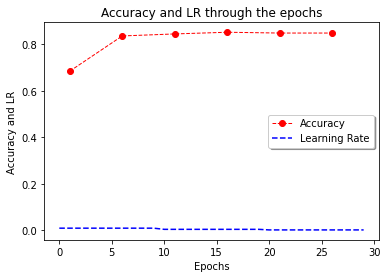

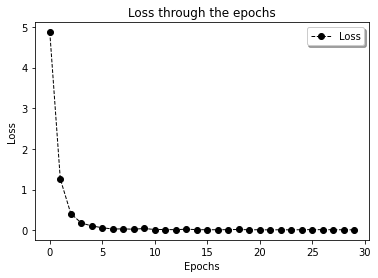

[0.6853388658367912, 0.8367911479944675, 0.8454356846473029, 0.8526970954356846, 0.8492392807745505, 0.8492392807745505]


In [ ]:
#### trend of accuracy and loss for different value of LR, epochs, gamma and step_size
#accuracy trend

e=range(NUM_EPOCHS)
ea=np.arange(1,NUM_EPOCHS,5)
fig, ax = plt.subplots()
ax.plot(ea, myacc, '--ro', linewidth=1, label='Accuracy')
ax.plot(e, mylr, '--b', label='Learning Rate')
legend = ax.legend(shadow=True)


plt.xlabel('Epochs') 
plt.ylabel('Accuracy and LR')  
#plt.plot(, linewidth=1) 
plt.title('Accuracy and LR through the epochs') 
plt.show()

fig, ax = plt.subplots()
ax.plot(e, myloss, '--ko', linewidth=1, label='Loss')
legend = ax.legend(shadow=True)
plt.title('Loss through the epochs') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.show()
print(myacc)

**Test**

In [ ]:
net=best_net
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:10<00:00,  1.10it/s]

Test Accuracy: 0.8613895610093328
